# Generalized Moment Correction for Long-Ranged Electrostatics

_Björn Stenqvist, Vidar Aspelin and Mikael Lund, Div. of Theoretical Chemistry, Lund University, Sweden, 2020_

In this notebook we test the validity of a variety of Wolf-inspired potentials and compare with a default Ewald summation on a simple box of water.

Article: "Generalized Moment Correction for Long-Ranged Electrostatics"

Install prerequisites using `conda`:
```bash
$ conda config --add channels omnia
$ conda install -c omnia openmm mdtraj packmol
```

To test the Openmm installation, run

```bash
python -m simtk.testInstallation
```

Also, Gromacs analysis tools (`gmx`) must be installed for parts of the analysis.

In [11]:
%matplotlib inline
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
import matplotlib, matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
import numpy as np, os
from matplotlib.font_manager import FontProperties
matplotlib.rcParams.update({'font.size': 12})

# simulation parameters

nsteps_eq  = 500000          # number of equilibration MD steps each of 2 fs, 500000
nsteps_pr  = 5000000         # number of production MD steps each of 2 fs, 5000000
nwater     = 2000            # number of water molecules
cutoff     = 0.96*nanometers # pair potential cutoff (0.96, 1.28, 1.6)
platform   = 'CPU'           # 'OpenCL', 'CUDA', 'CPU'

rho        = 216/18.6206**3 # density from gromacs spc216.gro
boxlen     = (nwater/rho)**(1/3)
volume     = (boxlen*angstrom)**3

runSystems=False
plotData=False

print('volume     = ', volume)
print('box length = ', boxlen*angstrom)
print('half box   = ', boxlen*angstrom/2)

try:
    workdir
except NameError:
    workdir=%pwd
    
%cd $workdir

tempdir = 'cutoff'+str(cutoff).replace(' ', '')
if not os.path.isdir(tempdir):
    %mkdir $tempdir
    
fontSizeLabel=10
fontSizeLegend=8
fontSizeLegend2=6

plt.rcParams.update(
    {
        'font.size': fontSizeLegend2,
        'figure.figsize': [3.513475, 2.713475],
        'xtick.labelsize':fontSizeLegend2,
        'ytick.labelsize':fontSizeLegend2,
        'legend.fontsize':fontSizeLegend
    }
)

volume     =  59780.185333609355 A**3
box length =  39.10080983612078 A
half box   =  19.55040491806039 A


In [ ]:
pf = Platform.getPlatformByName( 'OpenCL' ) # CPU, OpenCL
pf.getSpeed()

### Create initial box of water

First create a single water molecule pdb file, then use this to fill up a predefined box using the command line tool `packmol`. In this example, $N$ and $L$ are taken form the Gromacs `spc216.gro` file.

In [ ]:
%%writefile hoh.pdb
CRYST1   30.000   30.000   30.000  90.00  90.00  90.00 P 1           1
ATOM      1  OW  HOH A   1      27.552  11.051   7.172  1.00  0.00          O
ATOM      2  HW1 HOH A   1      27.900  10.721   8.050  1.00  0.00          H
ATOM      3  HW2 HOH A   1      26.606  11.355   7.281  1.00  0.00          H 
END

In [ ]:
# write input file for packmol
PACKMOL_INPUT = """ 
tolerance %f
filetype pdb
output %s

# hoh will be put in a box
# defined by the minimum coordinates x, y and z = 0. 0. 0. and maximum
# coordinates box_size box_size box_size That is, they will be put in a cube of side
# box_size (the keyword "inside cube 0. 0. 0. box_size") could be used as well.

structure %s
  number %d
  inside box 0. 0. 0. %f %f %f 
  add_box_sides 0.0
end structure
""" % (2.,'water.pdb','hoh.pdb', nwater, boxlen, boxlen, boxlen)

!echo '$PACKMOL_INPUT' > packmol_input.txt
!/usr/local/bin/packmol < packmol_input.txt > /dev/null

### Create OpenMM `System` classes for a variety of long-range correction schemes

Here the idea is to create all the different setups and add then to the `systemlist` dictionary. Ewald summation (and PME) can be setup using the default `NonbondedForce` class, while `CustomNonbondedForce` must be used for custom pair potentials as used in Wolf, Stenqvist etc.

For more information on how to control force objects and simulation, check,

* [OpenMM python API](http://docs.openmm.org).
* Lennard-Jones + Ewald at http://docs.openmm.org/7.0.0/userguide/theory.html#nonbondedforce
* Long range correction beyond cut-off: http://docs.openmm.org/7.0.0/userguide/theory.html#customnonbondedforce

In [ ]:
%cd $workdir
elec_to_kJmol = (
    constants.elementary_charge**2 *
    AVOGADRO_CONSTANT_NA / (4*np.pi*1.0*8.854187817e-12
                            * constants.farad/constants.meter)).value_in_unit(kilojoule_per_mole*nanometer)

def findForce(system, forcetype, add=True):
    """ Finds a specific force in the system force list - added if not found."""
    for force in system.getForces():
        if isinstance(force, forcetype):
            return force
    if add==True:
        system.addForce(forcetype())
        return findForce(system, forcetype)
    return None

def make_qpotential_system(topology, Rc=0.9*nanometers, moments=1000, ljcorr=True):
    ''' return a q-potential system (TO '''

    ff = ForceField('spce-custom.xml') # this will create a CustomNonbondedForce
    system = ff.createSystem(
        topology, nonbondedMethod=CutoffPeriodic,
        nonbondedCutoff=Rc, constraints=HBonds, rigidWater=True)
    
    def qPochhammerSymbol( Rc, moments ):
        if isinstance(Rc, Quantity):
            Rc = Rc / nanometer # strip unit
        qP = 1.0
        r = np.linspace(0, Rc, 5000)
        for i in range( moments ):
            qP *= (1 - (r/Rc)**(i+1) )
        return qP
 
    qP = Continuous1DFunction( qPochhammerSymbol(Rc, moments), 0*nanometers, Rc)

    nonbonded = findForce(system, CustomNonbondedForce)
    nonbonded.setEnergyFunction(
        '4 * epsilon * ( (sigma/r)^12 - (sigma/r)^6 ); sigma = 0.5 * (sigma1+sigma2); epsilon = sqrt( epsilon1*epsilon2 )'
    )
    nonbonded.setUseLongRangeCorrection( True )

    elec = copy.deepcopy(nonbonded)
    elec.setEnergyFunction('f * charge1 * charge2 * qP(r)/r')
    elec.addTabulatedFunction( 'qP', qP )         # 'qP(r)' can now be used in energy function
    elec.addGlobalParameter( 'f', elec_to_kJmol ) # 'lB' bjerrum length in nm and kJ/mol
    elec.setUseLongRangeCorrection( False )
    system.addForce(elec)

    print('qpot')
    print('    periodic boundaries:  ', nonbonded.usesPeriodicBoundaryConditions())
    print('    switching function:   ', nonbonded.getUseSwitchingFunction())
    print('    long-range correction:', nonbonded.getUseLongRangeCorrection())
    print('    cutoff distance:      ', nonbonded.getCutoffDistance())
    print('    energy function:      ', nonbonded.getEnergyFunction())
    print('')
    print('    periodic boundaries:  ', elec.usesPeriodicBoundaryConditions())
    print('    switching function:   ', elec.getUseSwitchingFunction())
    print('    long-range correction:', elec.getUseLongRangeCorrection())
    print('    cutoff distance:      ', elec.getCutoffDistance())
    print('    energy function:      ', elec.getEnergyFunction())
    
    return system

def make_SP3_system(topology, Rc=0.9*nanometers, ljcorr=True):
    ''' return a SP3 system '''

    ff = ForceField('spce-custom.xml') # this will create a CustomNonbondedForce
    system = ff.createSystem(
        topology, nonbondedMethod=CutoffPeriodic,
        nonbondedCutoff=Rc, constraints=HBonds, rigidWater=True)

    nonbonded = findForce(system, CustomNonbondedForce)
    nonbonded.setEnergyFunction(
        '4 * epsilon * ( (sigma/r)^12 - (sigma/r)^6 ); sigma = 0.5 * (sigma1+sigma2); epsilon = sqrt( epsilon1*epsilon2 )'
    )
    nonbonded.setUseLongRangeCorrection( True )

    elec = copy.deepcopy(nonbonded)
    elec.setEnergyFunction('f * charge1 * charge2 * 1/r * ( 1 - 1.75*r/Rc + 5.25*(r/Rc)^5 - 7*(r/Rc)^6 + 2.5*(r/Rc)^7 )')
    elec.addGlobalParameter( 'Rc', Rc )           # 'Rc' can now be used in energy function
    elec.addGlobalParameter( 'f', elec_to_kJmol ) # 'lB' bjerrum length in nm and kJ/mol
    elec.setUseLongRangeCorrection( False )
    system.addForce(elec)

    print('SP3')
    print('    periodic boundaries:  ', nonbonded.usesPeriodicBoundaryConditions())
    print('    switching function:   ', nonbonded.getUseSwitchingFunction())
    print('    long-range correction:', nonbonded.getUseLongRangeCorrection())
    print('    cutoff distance:      ', nonbonded.getCutoffDistance())
    print('    energy function:      ', nonbonded.getEnergyFunction())
    print('')
    print('    periodic boundaries:  ', elec.usesPeriodicBoundaryConditions())
    print('    switching function:   ', elec.getUseSwitchingFunction())
    print('    long-range correction:', elec.getUseLongRangeCorrection())
    print('    cutoff distance:      ', elec.getCutoffDistance())
    print('    energy function:      ', elec.getEnergyFunction())
    
    return system

def make_SP1_system(topology, Rc=0.9*nanometers, ljcorr=True):
    ''' return a SP1 system '''

    ff = ForceField('spce-custom.xml') # this will create a CustomNonbondedForce
    system = ff.createSystem(
        topology, nonbondedMethod=CutoffPeriodic,
        nonbondedCutoff=Rc, constraints=HBonds, rigidWater=True)

    nonbonded = findForce(system, CustomNonbondedForce)
    nonbonded.setEnergyFunction(
        '4 * epsilon * ( (sigma/r)^12 - (sigma/r)^6 ); sigma = 0.5 * (sigma1+sigma2); epsilon = sqrt( epsilon1*epsilon2 )'
    )
    nonbonded.setUseLongRangeCorrection( True )

    elec = copy.deepcopy(nonbonded)
    elec.setEnergyFunction('f * charge1 * charge2 * ( 1/r - 1/Rc + 1/Rc^2 * (r-Rc) )')
    elec.addGlobalParameter( 'Rc', Rc )           # 'Rc' can now be used in energy function
    elec.addGlobalParameter( 'f', elec_to_kJmol ) # 'lB' bjerrum length in nm and kJ/mol
    elec.setUseLongRangeCorrection( False )
    system.addForce(elec)

    print('SP1')
    print('    periodic boundaries:  ', nonbonded.usesPeriodicBoundaryConditions())
    print('    switching function:   ', nonbonded.getUseSwitchingFunction())
    print('    long-range correction:', nonbonded.getUseLongRangeCorrection())
    print('    cutoff distance:      ', nonbonded.getCutoffDistance())
    print('    energy function:      ', nonbonded.getEnergyFunction())
    print('')
    print('    periodic boundaries:  ', elec.usesPeriodicBoundaryConditions())
    print('    switching function:   ', elec.getUseSwitchingFunction())
    print('    long-range correction:', elec.getUseLongRangeCorrection())
    print('    cutoff distance:      ', elec.getCutoffDistance())
    print('    energy function:      ', elec.getEnergyFunction())
    
    return system

def make_ewald_system(topology, Rc=0.9*nanometers, method=Ewald, ljcorr=True):
    ''' returns an Ewald system '''
    ff = ForceField('spce.xml') # this will create a NonbondedForce
    
    system = ff.createSystem(topology, nonbondedMethod=method,nonbondedCutoff=Rc, constraints=HBonds, rigidWater=True)
    
    nonbonded = findForce(system, NonbondedForce)
    nonbonded.setUseDispersionCorrection( ljcorr )

    print('ewald')
    print('    err. tolerance:       ', nonbonded.getEwaldErrorTolerance())
    print('    LJ switching function:', nonbonded.getUseSwitchingFunction())
    print('    LJ correction:        ', nonbonded.getUseDispersionCorrection())
    print('    cutoff distance:      ', nonbonded.getCutoffDistance())
 
    return system

pdb = PDBFile('water.pdb')

# here we define our list of system incl. plotting properties. All files from simulation
# and analysis will be prefixed with 'qpot.', 'ewald.', etc.

try:
    topology=pdb.topology
    Rc=cutoff
    ff = ForceField('spce-custom.xml') # this will create a CustomNonbondedForce
    system = ff.createSystem(topology, nonbondedMethod=CutoffPeriodic,nonbondedCutoff=Rc, constraints=HBonds, rigidWater=True)
except: pass

from collections import OrderedDict

systemlist = OrderedDict([
    ('ewald', {
        'system': make_ewald_system( pdb.topology, Rc=cutoff ),
        'run': runSystems, 'color': 'black', 'label': 'No', 'ls':'-', 'alpha':1, 'plot':plotData, 'linewidth':2
    }),
    ('SP1', {
        'system': make_SP1_system( pdb.topology, Rc=cutoff ),
        'run': runSystems, 'color': 'magenta', 'label': 'SP1', 'ls':':', 'alpha':0.8, 'plot':plotData, 'linewidth':1
    }),
    ('qpot1', {
        'system': make_qpotential_system( pdb.topology, Rc=cutoff, moments=1 ),
        'run': runSystems, 'color': 'red', 'label': '$q$ ($n=1$)', 'ls':'-', 'alpha':0.8, 'plot':plotData, 'linewidth':1
    }),
    ('qpot2', {
        'system': make_qpotential_system( pdb.topology, Rc=cutoff, moments=2 ),
        'run': runSystems, 'color': 'orange', 'label': '$q$ ($n=2$)', 'ls':'-', 'alpha':0.8, 'plot':plotData, 'linewidth':1
    }),
    ('qpot3', {
        'system': make_qpotential_system( pdb.topology, Rc=cutoff, moments=3 ),
        'run': runSystems, 'color': 'yellow', 'label': '$q$ ($n=3$)', 'ls':'-', 'alpha':0.8, 'plot':plotData, 'linewidth':1
    }),
    ('qpot4', {
        'system': make_qpotential_system( pdb.topology, Rc=cutoff, moments=4 ),
        'run': runSystems, 'color': 'green', 'label': '$q$ ($n=4$)', 'ls':'-', 'alpha':0.8, 'plot':plotData, 'linewidth':1
    }),
    ('qpot5', {
        'system': make_qpotential_system( pdb.topology, Rc=cutoff, moments=5 ),
        'run': runSystems, 'color': 'cyan', 'label': '$q$ ($n=5$)', 'ls':'-', 'alpha':0.8, 'plot':plotData, 'linewidth':1
    }),
    ('qpot6', {
        'system': make_qpotential_system( pdb.topology, Rc=cutoff, moments=6 ),
        'run': runSystems, 'color': 'blue', 'label': '$q$ ($n=6$)', 'ls':'-', 'alpha':0.8, 'plot':plotData, 'linewidth':1
    }),
    ('qpot7', {
        'system': make_qpotential_system( pdb.topology, Rc=cutoff, moments=7 ),
        'run': runSystems, 'color': 'purple', 'label': '$q$ ($n=7$)', 'ls':'-', 'alpha':0.8, 'plot':plotData, 'linewidth':1
    }),
    ('qpot8', {
        'system': make_qpotential_system( pdb.topology, Rc=cutoff, moments=8 ),
        'run': runSystems, 'color': 'grey', 'label': '$q$ ($n=8$)', 'ls':'-', 'alpha':0.8, 'plot':plotData, 'linewidth':1
    }),
    ('qpot', {
        'system': make_qpotential_system( pdb.topology, Rc=cutoff ),
        'run': runSystems, 'color': 'black', 'label': '$q$ ($n=\infty$)', 'ls':'-', 'alpha':0.8, 'plot':plotData, 'linewidth':1
    })
])

In [ ]:
%cd $tempdir

# Simulations
Here we perform the actual MD simulation, incl. minimization of all defined systems

In [ ]:
def simulate(ensemble, nsteps_in, postfix):
    %cd $tempdir

    for name, prop in systemlist.items(): # loop over systems

        if prop['run']:
            print(name)
            if ensemble == 'nvt':
                print('    preparing ensemble: NVT')
                integrator = LangevinIntegrator( 298.15*kelvin, 1.0/picoseconds, timestep )
                integrator.setConstraintTolerance(0.00001)
            elif ensemble == 'nve':
                print('    preparing ensemble: NVE')
                integrator = VerletIntegrator( timestep )
                integrator.setConstraintTolerance(0.00001)
            elif ensemble == 'npt':
                print('    preparing ensemble: NPT')
                barostat = MonteCarloBarostat(1.0*bar, 298.15*kelvin, 25) 
                prop['system'].addForce(barostat)
                integrator = LangevinIntegrator( 298.15*kelvin, 1.0/picoseconds, timestep )
                integrator.setConstraintTolerance(0.00001)
            else:
                print('    Can not find the chosen ensemble!')

            _platform = Platform.getPlatformByName( platform ) # CPU, OpenCL
            _properties = {'CudaDeviceIndex': '0', 'CudaPrecision': 'mixed'}
            #_properties = {'OpenCLDeviceIndex': '0', 'OpenCLPrecision': 'mixed'}
            sim = Simulation(pdb.topology, prop['system'], integrator, _platform, _properties )
            sim.context.setPositions(pdb.positions) # set particle positions

            if os.path.isfile( name+'.chk' ):
                with open( name+'.chk', 'rb') as f:
                    print('    loading restart file.')
                    sim.context.loadCheckpoint( f.read() )
            else:
                print('    minimizing energy...')
                sim.reporters.clear()
                %time sim.minimizeEnergy( tolerance=50*kilojoule/mole, maxIterations=1000 )
                sim.context.setVelocitiesToTemperature( 298.15*kelvin ) # initial random velocities

            print('    running Production...')
            sim.reporters.clear()
            sim.reporters.append( DCDReporter( name+postfix+'.dcd', sampleevery) )

            sim.reporters.append( StateDataReporter(name+postfix+'.energy', sampleevery, step=True, potentialEnergy=True,
                                                    totalEnergy=True, temperature=True, density=True) )

            sim.reporters.append( StateDataReporter(stdout, 5000, step=True, potentialEnergy=True, 
                                                    totalEnergy=True, temperature=True, density=True, 
                                                    separator='\t', progress=True, totalSteps = nsteps_in) )

            %time sim.step( nsteps_in )

            with open( name+'.chk', 'wb') as f:
                print('    saving restart file.')
                f.write( sim.context.createCheckpoint() )

            # save final configuration to PDB file
            # todo: something is fishy here... water molecules are outside the box
            #       in pdb although the trajectory looks fine. Å->nm problem?
            positions = sim.context.getState( getPositions=True ).getPositions()
            PDBFile.writeFile(sim.topology, positions, open( name+postfix+'.pdb', 'w'))
            print()
    print('done.')
    
simulate('nvt',nsteps_eq,'_eqnvt') # equilibration NVT
simulate('npt',nsteps_eq,'_eqnpt') # equilibration NPT
simulate('npt',nsteps_pr,'_npt')   # production NVT
simulate('nve',nsteps_eq,'_eqnve') # equilibration NVE
simulate('nve',2*nsteps_eq,'_nve') # production NVE

# Analysis
### Diffusion coefficient

In [ ]:
import mdtraj as md
timestep_xtc=timestep/picoseconds*sampleevery

for name, prop in systemlist.items():
    if prop['run']:
        print(name)
        dcdfile = name+'_nve.dcd'
        xtcfile = name+'_nve.xtc'
        pdbfile = name+'_nve.pdb'
        xvgfile = name+'_nve.xvg'
        !rm -f $xtcfile
        !mdconvert $dcdfile -o $xtcfile
        !gmx trjconv -f $xtcfile -o $xtcfile -timestep $timestep_xtc
        !echo -n "0 0" | gmx msd -quiet -f $xtcfile -s $pdbfile -o $xvgfile -rmcomm

### Oxygen-oxygen radial distribution function

In [ ]:
plt.rcParams.update({'figure.figsize': [3.513475, 2.713475]})
lwA = 1.2;

import mdtraj as md

for name, prop in systemlist.items():
    if prop['plot']:
        print(name)

        rdffile = name+'OO.rdf'
        if os.path.isfile( rdffile ):
            rdf = np.loadtxt( rdffile )
        else:
            if os.path.isfile(name+'.dcd'):
                traj = md.load(name+'.dcd', top=name+'.pdb')
                sel = traj.top.select('name O')
                OOpairs = traj.top.select_pairs('name O', 'name O')
                rdf = md.compute_rdf( traj, pairs=OOpairs, bin_width=0.005, r_range=[0.2, boxlen/2/10] )
                np.savetxt( rdffile, rdf )
        
        if prop['label']=='No':
            plt.plot( rdf[0], rdf[1], color=prop['color'],ls=prop['ls'], alpha=prop['alpha'])
        else:
            plt.plot( rdf[0], rdf[1], label=prop['label'], color=prop['color'],ls=prop['ls'], alpha=prop['alpha'])

plt.xlim(0.1, 1.9)
plt.ylim(0.0,3.5)
plt.xlabel(r'$r$ / nm')
plt.ylabel(r'$g_{OO}(r)$')
plt.title(r'Cutoff '+str(cutoff))
plt.legend(loc=(1,0), frameon=False,ncol=1, labelspacing=0.55)
plt.savefig('spce-gofr.pdf', bbox_inches='tight')

In [ ]:
import mdtraj as md

for name, prop in systemlist.items():
    if prop['plot']:
        rdffile = name+'OO.rdf'
        if os.path.isfile( rdffile ):
            rdf = np.loadtxt( rdffile )
        else:
            if os.path.isfile(name+'.dcd'):
                traj = md.load(name+'.dcd', top=name+'.pdb')
                sel = traj.top.select('name O')
                OOpairs = traj.top.select_pairs('name O', 'name O')
                rdf = md.compute_rdf( traj, pairs=OOpairs, bin_width=0.005, r_range=[0.2, boxlen/2/10] )
                np.savetxt( rdffile, rdf )

### Static dielectric constant

The exact formula for $\epsilon_r$ is not given in the `mdtraj` documentation, but can be found in the source code on github,

https://github.com/mdtraj/mdtraj/blob/master/mdtraj/geometry/thermodynamic_properties.py#L90

In [ ]:
def getChargeVector( force, stripunit=True ):
    ''' Extract particle charge array from force object if available
    
    Note that this function assumes that charge is located at parameter
    position 0 which is default in NonbondedForce while it can be anywhere
    in CustomNonbondedForce, following the order in which
    parameters were added in python/xml.
    '''
    if isinstance(force, (NonbondedForce, CustomNonbondedForce) ):
        if 'getParticleParameters' in dir(force):
            chargelist = []
            for i in range( force.getNumParticles() ):
                charge = force.getParticleParameters( i )[ 0 ]
                if stripunit:
                    if isinstance(charge, Quantity):
                        charge = charge / elementary_charge # strip unit
                chargelist.append( charge )
            return chargelist
    return None
    
el = 1.60217656535*(10^(-19))
nm = 1e-9
D = 0.020819434*nm*el
for name, prop in systemlist.items():

        for force in prop['system'].getForces():
            if os.path.isfile(name+'.dcd'):
                if isinstance(force, (NonbondedForce, CustomNonbondedForce) ):
                    charges = getChargeVector( force )
                    traj = md.load(name+'.dcd', top=name+'.pdb')

                    l = int(len(traj)*0.8) # Get length of simulation (remove equilibration)
                    startV = 1000 # Start after equilibration
                    
                    bins=10
                    dip_mom2 = [];
                    eps = np.arange(bins)
                    for k in range(bins):
                        tmp = md.dipole_moments(traj[int(startV+1+k*l/10):int(startV+l+k*l/10)], charges)
                        dipw = 2.351*D # Dipole moment of a spc/e water molecule
                        tmp2 = tmp*tmp*nm*el/dipw*nm*el/dipw/1000
                        dip2 = np.mean(tmp2,axis=0)

                        dip_mom2.append(np.mean(dip2) )
                        eps[k] = md.static_dielectric( traj[int(startV+1+k*l/10):int(startV+l+k*l/10)], charges, temperature=298.15)

                    print(name, ': diel. const.', np.average(eps), np.std(eps))

In [ ]:
t = pd.DataFrame(systemlist).T
t.diel.to_json('spce-dielectric.json')
t.diel

## Gromacs analysis

We now generate a topology (top/tpr) file for Gromacs in order to use use their analysis tools, in particular for dipol correlations. These files are identitical for all electrostatic schemes.
**NOTE**: Depending on the size of the water box, `grompp` may complain that the cut-off is too short. Fix this by increasing the verlet tolerance. It will not matter for the analysis, but consider making a slightly larger system. 

In [ ]:
%%bash -s "$workdir"

cp $1/water.mdp .
cp $1/water.pdb .
cp $1/water.gro .

source $HOME/opt/bin/GMXRC.bash
rm -fR 
echo -n "6\n" | gmx -quiet -nobackup pdb2gmx -f water.pdb -o water.gro -p water.top -n water.ndx -water spce
gmx -quiet -nobackup grompp -f water.mdp -c water.gro -p water.top -o water.tpr -maxwarn 10

### Convert trajectory to XTC format and calculate dipolar correlations

See description of the `-g` option in `gmx dipoles`, relating to http://manual.gromacs.org/programs/gmx-dipoles.html (Nymand/Linse).

In [ ]:
for name, prop in systemlist.items():

    if os.path.isfile(name+'.dcd'):

        print(name)

        if not os.path.isfile( name+'.gkr.xvg' ):
            traj = md.load(name+'.dcd', top=name+'.pdb')
            traj.save_xtc(name+'.xtc')

            !source /home/mikael/opt/bin/GMXRC.bash ; echo -n "0" | gmx -quiet -nobackup dipoles -f $name'.xtc' -s water.tpr -temp 298.15 -g $name'.gkr.xvg'

            print()
print('done.')

In [ ]:
import pickle
with open('data.pickle', 'wb') as f:
    pickle.dump(systemlist, f, protocol=pickle.HIGHEST_PROTOCOL)  

# Figures in article

## Figure 1: Short-range function

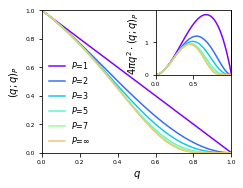

In [4]:
def qPochhammer():
    plt.rcParams.update({'figure.figsize': [3.513475, 2.713475]})
    lwA = 1.5;
    cmap = plt.get_cmap('rainbow')
    clist = cmap((np.linspace(0, 1, 8)))

    def qPotential(q,P):
        qP = np.ones(len(q));
        ones = np.ones(len(q))
        for n in range(1, P+1):
            qP *= (ones-q**n)
        return qP

    q = np.linspace(0,1,100)
    q1 = qPotential(q,1)
    q2 = qPotential(q,2)
    q3 = qPotential(q,3)
    q5 = qPotential(q,5)
    q7 = qPotential(q,7)
    q300 = qPotential(q,300) # 300 \approx \infty
    
    plt.plot(q,q1, lw=lwA, color=clist[0],label=r'$P$=1',ls='-')
    plt.plot(q,q2, lw=lwA, color=clist[1],label=r'$P$=2',ls='-')
    plt.plot(q,q3, lw=lwA, color=clist[2],label=r'$P$=3',ls='-')
    plt.plot(q,q5, lw=lwA, color=clist[3],label=r'$P$=5',ls='-')
    plt.plot(q,q7, lw=lwA, color=clist[4],label=r'$P$=7',ls='-')
    plt.plot(q,q300, lw=lwA, color=clist[5],label=r'$P$=$\infty$',ls='-')

    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.xlabel('$q$',fontsize=fontSizeLabel)
    plt.ylabel(r'$(q;q)_P$',fontsize=fontSizeLabel)
    plt.legend(loc='lower left', frameon=False)

    # plot inset
    inset = plt.axes([0.6, 0.55, 0.3, 0.33], facecolor='white')

    plt.plot(q,4*np.pi*q**2*q1, lw=lwA, color=clist[0],label=r'$P$=1',ls='-')
    inset.plot(q,4*np.pi*q**2*q2, lw=lwA, color=clist[1],label=r'$P$=2',ls='-')
    inset.plot(q,4*np.pi*q**2*q3, lw=lwA, color=clist[2],label=r'$P$=3',ls='-')
    inset.plot(q,4*np.pi*q**2*q5, lw=lwA, color=clist[3],label=r'$P$=5',ls='-')
    inset.plot(q,4*np.pi*q**2*q7, lw=lwA, color=clist[4],label=r'$P$=7',ls='-')
    inset.plot(q,4*np.pi*q**2*q300, lw=lwA, color=clist[5],label=r'$P$=$\infty$',ls='-')

    inset.set_xticks(np.arange(0, 0.5+1e-9, 0.5))
    inset.set_yticks(np.arange(0, 1.0+1e-9, 1.0))
    plt.ylabel(r'$4\pi q^2\cdot (q;q)_P$',fontsize=fontSizeLabel)
    inset.set_xlim((0.0, 1.0))
    inset.set_ylim((0.0, 2.0))

    plt.gcf().subplots_adjust(left=0.15,bottom=0.15)
    plt.savefig('qPochhammer.pdf',bbox_inches='tight')
qPochhammer()

## Figure 3: Radial distribution functions

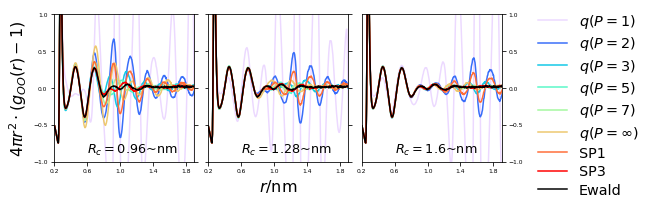

In [8]:
def plot_RDF():
    plt.rcParams.update({'figure.figsize': [8.013475, 2.713475]})
    from matplotlib import container
    cmap = plt.get_cmap('rainbow')
    clist = cmap((np.linspace(0, 1, 8)))
    lwA = 1.5;
    datadir = '/home/SI-qpotential/bulk' # path to simulation output
    os.chdir(datadir)

    fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
    lines = []

    plt.rcParams.update(
        {
            'font.size': 2*fontSizeLegend2,
            'figure.figsize': [3.513475, 2.713475],
            'xtick.labelsize':2*fontSizeLegend2,
            'ytick.labelsize':2*fontSizeLegend2,
            'legend.fontsize':1.8*fontSizeLegend
        }
    )

    fontSizeLabelT = 1.6*fontSizeLabel

    filenames=['qpot1OO','qpot2OO','qpot3OO','qpot5OO','qpot7OO','qpotOO','SP1OO','SP3OO']
    names=[r'$q(P=1)$',r'$q(P=2)$',r'$q(P=3)$',r'$q(P=5)$',r'$q(P=7)$',r'$q(P=\infty)$','SP1','SP3']

    def plotSingleCutoff(ax,cutoffString,cutoff,lines):
        cnt=0
        for filename in filenames:
            data = np.loadtxt(cutoffString+str(filename)+'.rdf')
            alphaV=1
            if cnt == 0:
                alphaV=0.15
            lines += ax.plot(data[0,:],4*np.pi*(data[1,:]-1)*data[0,:]**2, lw=lwA, color=clist[cnt],label=names[cnt],ls='-',alpha=alphaV)
            cnt=cnt+1

        dataEwald = np.loadtxt('cutoff0.96nm/ewaldOO.rdf')
        lines += ax.plot(dataEwald[0,:],4*np.pi*(dataEwald[1,:]-1)*data[0,:]**2, lw=lwA,label='Ewald', color='black',ls='-')
        ax.set_xlim((0.2, 1.9))
        ax.set_ylim((-1.0, 1.0))
        ax.set_xticks(np.arange(0.2, 1.9+1e-9, 0.4))
        ax.yaxis.set_ticks_position('both')
        ax.text(0.6,-0.88, r'$R_c=$'+str(cutoff)+'~nm', fontsize=1.6*fontSizeLegend)
        return lines

    lines = plotSingleCutoff(ax1,'cutoff0.96nm/',0.96,lines)
    lines = plotSingleCutoff(ax2,'cutoff1.28nm/',1.28,lines)
    lines = plotSingleCutoff(ax3,'cutoff1.6nm/',1.6,lines)

    ax1.set_ylabel(r'$4\pi r^2\cdot\left(g_{OO}(r)-1\right)$',fontsize=fontSizeLabelT)
    ax2.set_xlabel(r'$r$/nm',fontsize=fontSizeLabelT)
    ax2.set_yticklabels([])
    ax3.legend(frameon=False,ncol=1,bbox_to_anchor=(1.17, 1.1), labelspacing=0.3)
    ax3.yaxis.tick_right()
    ax3.tick_params(labelleft=False, labelright=True)
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(1,0))
    ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    os.chdir(workdir)
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.savefig('spce_rdf_jac.pdf',bbox_inches='tight')
plot_RDF()

## Figure 4: Dipole-dipole correlations

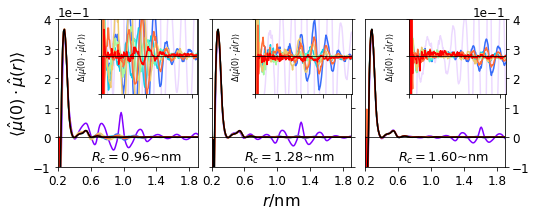

In [10]:
def plot_MuMu():
    plt.rcParams.update({'figure.figsize': [8.013475, 2.713475]})
    from matplotlib import container
    cmap = plt.get_cmap('rainbow')
    clist = cmap((np.linspace(0, 1, 8)))
    lwA = 1.5;
    datadir = '/home/SI-qpotential/bulk' # path to simulation output
    os.chdir(datadir)

    plt.rcParams.update(
        {
            'font.size': 2*fontSizeLegend2,
            'xtick.labelsize':2*fontSizeLegend2,
            'ytick.labelsize':2*fontSizeLegend2,
            'legend.fontsize':1.8*fontSizeLegend
        }
    )
    fontSizeLabelT = 1.6*fontSizeLabel

    fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
    lines = []
    filenames=['qpot1','qpot2','qpot3','qpot5','qpot7','qpot','SP1','SP3']
    names=[r'$q(P=1)$',r'$q(P=2)$',r'$q(P=3)$',r'$q(P=5)$',r'$q(P=7)$',r'$q(P=\infty)$','SP1','SP3']

    def plotSingleCutoff(ax,cutoffString,cutoff,lines,shift):
        dataEwald = np.loadtxt(cutoffString+'ewald.gkr.xvg',skiprows=28)
        dataEwald = dataEwald[0:300,:]
        cnt=0
        for filename in filenames:
            data = np.loadtxt(cutoffString+str(filename)+'.gkr.xvg',skiprows=28)
            data = data[0:300,:]
            lines += ax.plot(data[:,0],data[:,2]-dataEwald[:,2]*0, lw=lwA, color=clist[cnt],label=names[cnt],ls='-')
            cnt=cnt+1

        data = dataEwald
        lines += ax.plot(data[:,0],(data[:,2]*(1+0*dataEwald[:,2]**(-1))), lw=lwA, color='black',label='Ewald',ls='-')
        ax.plot(data[:,0],data[:,0]*0, lw=lwA*0.5, color='black',ls='-')

        ax.set_xlim((0.23, 1.9))
        ax.set_ylim((-0.1, 0.4))
        ax.set_xticks(np.arange(0.2, 1.9+1e-9, 0.4))

        inset = plt.axes([0.2+shift, 0.5, 0.167, 0.38], facecolor='white')
        dataEwald = np.loadtxt(cutoffString+'ewald.gkr.xvg',skiprows=28)
        dataEwald = dataEwald[0:300,:]
        cnt=0
        for filename in filenames:
            data = np.loadtxt(cutoffString+str(filename)+'.gkr.xvg',skiprows=28)
            data = data[0:300,:]
            alpha = 1
            if cnt == 0:
                alpha = 0.15
            lines += inset.plot(data[:,0],data[:,2]-dataEwald[:,2],alpha=alpha, lw=lwA, color=clist[cnt],label=names[cnt],ls='-')
            cnt=cnt+1

        data = dataEwald
        lines += inset.plot(data[:,0],(data[:,2]*(dataEwald[:,2]**(-1))), lw=lwA, color='black',label='Ewald',ls='-')
        inset.plot(data[:,0],data[:,0]*0, lw=lwA*0.5, color='black',ls='-')

        inset.set_xlim((0.2, 1.9))
        inset.set_xticks(np.arange(0.2, 1.9+1e-9, 0.4))
        inset.set_xticklabels([])
        inset.set_yticklabels([])
        inset.set_ylim((-0.005, 0.005))
        inset.set_ylabel('$\Delta\langle \hat{\mu}(0)\cdot\hat{\mu}(r) \\rangle $',fontsize=fontSizeLabelT/2)

    plotSingleCutoff(ax1,'cutoff0.96nm/',0.96,lines,0)
    plotSingleCutoff(ax2,'cutoff1.28nm/',1.28,lines,0.267)
    plotSingleCutoff(ax3,'cutoff1.6nm/',1.6,lines,0.534)

    ax1.set_ylabel('$\langle \hat{\mu}(0)\cdot\hat{\mu}(r) \\rangle $',fontsize=fontSizeLabelT)
    ax2.set_xlabel(r'$r$/nm',fontsize=fontSizeLabelT)
    ax1.text(0.6,-0.08, r'$R_c=0.96$~nm', fontsize=1.6*fontSizeLegend)
    ax2.text(0.6,-0.08, r'$R_c=1.28$~nm', fontsize=1.6*fontSizeLegend)
    ax3.text(0.6,-0.08, r'$R_c=1.60$~nm', fontsize=1.6*fontSizeLegend)
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax2.yaxis.set_ticks_position('both')
    ax2.set_yticklabels([])
    ax3.yaxis.tick_right()
    ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    os.chdir(workdir)
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.savefig('spce_mumu_diff.pdf',bbox_inches='tight')
with np.errstate(divide='ignore', invalid='ignore'): # Ignore divide by zero and invalid value warnings
    plot_MuMu()